In [19]:
import numpy as np
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import datetime
import os, sys
import importlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
import seaborn as sns

sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#sys.path.insert(0, 'C:/Users/Ragnar/Documents/git_code/MMDGraph')
import covariance
importlib.reload(sys.modules['covariance'])

import mmdutils
importlib.reload(sys.modules['mmdutils'])
import  graphical_lasso 
import gradient_descent

import mgarch
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# Install R-package

In [2]:
# utils = importr('utils')
# utils.install_packages('spectralGraphTopology')

# Load data

In [3]:
min_date = '2021-08-01 04:00:00'
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]


# Create dictionary to store which company belongs to which sector
sector_classification = dict()
for i in range(asset_profiles.shape[0]):
    if asset_profiles['sector'].iloc[i] not in sector_classification.keys():
        sector_classification[asset_profiles['sector'].iloc[i]] = list()
    sector_classification[asset_profiles['sector'].iloc[i]].append(asset_profiles['ticker'].iloc[i])
    
price_pivot

ticker,NUE,MOS,FMC,VMC,NEM,IFF,FCX,ALB,LYB,MLM,...,AWK,DTE,DUK,ATO,ED,EIX,LNT,PEG,WEC,ETR
date,,,,,,,,,,,,,,,,,,,,,
2021-08-03,0.043983,0.046368,0.001687,0.007047,0.010752,0.003470,0.000546,0.000387,0.013059,-0.000827,...,0.017552,0.004497,0.003947,0.001405,0.004687,0.005249,0.013935,0.010287,0.009563,0.003758
2021-08-04,-0.016732,-0.023568,-0.079395,-0.006602,-0.012690,-0.015576,-0.027391,-0.000677,-0.032457,0.010072,...,0.006652,-0.002882,0.001125,-0.002914,0.000267,-0.009615,-0.000834,-0.003786,0.002298,-0.002504
2021-08-05,-0.032850,0.002936,-0.056306,-0.010407,-0.009910,0.001960,0.005594,0.055389,-0.003408,-0.009935,...,0.017971,0.012989,0.011181,0.019134,0.005992,0.006722,0.008970,0.009908,0.006760,0.026171
2021-08-06,0.027210,0.025407,0.022065,0.018721,-0.023624,0.019924,0.027783,0.036337,0.028352,0.011108,...,-0.012433,0.002093,-0.009028,-0.004154,0.002652,-0.002901,0.005442,-0.000626,-0.001764,-0.003482
2021-08-09,0.032725,0.033415,0.006692,0.011361,-0.016518,0.017521,-0.010911,0.020390,0.001909,0.007256,...,0.001542,0.002672,-0.007602,0.002277,0.007256,0.006696,-0.001811,-0.000470,0.000208,0.006951
2021-08-10,0.091440,0.032929,-0.004701,0.022183,-0.013517,0.016899,0.047143,0.032528,0.039553,0.023735,...,-0.006287,0.000834,0.007041,-0.002277,0.004329,0.007905,-0.002970,-0.014677,-0.002391,0.017077
2021-08-11,0.038374,0.014164,0.007199,0.031887,0.020630,0.002746,0.013256,-0.012800,0.021757,0.031879,...,-0.002560,0.001499,0.002243,0.002475,0.009380,0.022298,0.005275,0.009966,0.003221,0.011904
2021-08-12,0.020327,-0.006467,-0.012764,-0.005444,-0.015475,-0.004411,-0.008817,0.002328,-0.008913,-0.003798,...,0.010708,-0.001916,-0.004390,-0.005652,0.001684,-0.001927,-0.002799,0.005024,-0.001385,-0.002940
2021-08-13,0.007398,-0.010375,-0.006868,-0.013451,0.008363,0.004219,-0.007583,-0.005596,0.000666,-0.009040,...,0.008250,0.002914,0.002929,0.008909,0.006323,-0.000526,0.006736,0.013534,0.006360,0.010889


In [4]:
sector_classification['Industrials']

['MMM',
 'ALK',
 'ALLE',
 'AAL',
 'AME',
 'AOS',
 'ADP',
 'AVY',
 'BA',
 'CHRW',
 'CARR',
 'CAT',
 'CTAS',
 'CPRT',
 'CSX',
 'CMI',
 'DE',
 'DAL',
 'DOV',
 'ETN',
 'EMR',
 'EFX',
 'EXPD',
 'FAST',
 'FDX',
 'GNRC',
 'GD',
 'GE',
 'GPN',
 'GWW',
 'HON',
 'HWM',
 'HII',
 'IEX',
 'INFO',
 'ITW',
 'IR',
 'J',
 'JBHT',
 'JCI',
 'KSU',
 'LHX',
 'LMT',
 'MAS',
 'NLSN',
 'NSC',
 'NOC',
 'ODFL',
 'OTIS',
 'PCAR',
 'PH',
 'PAYX',
 'PNR',
 'PWR',
 'RTX',
 'RSG',
 'RHI',
 'ROK',
 'ROP',
 'SNA',
 'LUV',
 'SWK',
 'TXT',
 'TT',
 'TDG',
 'UNP',
 'UAL',
 'UPS',
 'URI',
 'VRSK',
 'WAB',
 'WM',
 'XYL']

In [76]:
from sklearn.covariance import MinCovDet, LedoitWolf
x = price_pivot.loc[price_pivot.index > datetime.datetime.strptime('2021-06-01', '%Y-%d-%m').date()]
x = x.dropna(axis = 1)
# x = x.loc[:, x.columns.isin(sector_classification['Industrials'])]
corr_x = np.corrcoef(np.array(x).T)
x.shape

x_scaled = np.array(x)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_scaled)

mcd = MinCovDet(random_state=0).fit(x_scaled)
mcd_corr_x = mcd.covariance_

lwolf = LedoitWolf().fit(x_scaled)
lwolf_corr_x = covariance.corrMat(lwolf.covariance_)



c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Remove market effect with median regression

In [6]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500
    

In [7]:
sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)
sp500

,date,price,return,log_return
1,2012-01-17,1293.67,1.003553,0.003547
2,2012-01-18,1308.04,1.011108,0.011047
3,2012-01-19,1314.50,1.004939,0.004927
4,2012-01-20,1315.38,1.000669,0.000669
5,2012-01-23,1316.00,1.000471,0.000471
...,...,...,...,...
2513,2022-01-07,4677.03,0.995950,-0.004058
2514,2022-01-10,4670.29,0.998559,-0.001442
2515,2022-01-11,4713.07,1.009160,0.009118
2516,2022-01-12,4726.35,1.002818,0.002814


In [8]:
import statsmodels.api as sm

returns_with_index = pd.merge(x, sp500, how = 'left', left_index= True, right_on= 'date')
# returns_with_index


In [9]:
covariates = pd.DataFrame({'market': returns_with_index.loc[:,'log_return']})
covariates['const'] = 1


x_no_market = dict()
for tick in x.columns:
    model_robust = sm.QuantReg(returns_with_index[tick], covariates)
    results_robust = model_robust.fit(q = 0.5, max_iter = 10000)
    y_hat_rob = model_robust.predict(results_robust.params)
    x_no_market[tick] = y_hat_rob-np.array(returns_with_index[tick])


x_no_market = pd.DataFrame(x_no_market, index = x.index)


x_no_market_scaled = np.array(x)
scaler = StandardScaler()
x_no_market_scaled = scaler.fit_transform(x_no_market_scaled)

# Personal graphical lasso

Let's start with a simple test

In [65]:
import numpy as np
from sklearn.covariance import GraphicalLasso
true_cov = np.array([[1, 0.0, 0.2, 0.0],
                     [0.0, 1, 0.0, 0.0],
                     [0.2, 0.0, 1, 0.1],
                     [0.0, 0.0, 0.1, 1]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0],
                                  cov=true_cov,
                                  size=400)


np.linalg.inv(true_cov)
X_TEST_scaled = scaler.fit_transform(X)

In [70]:
importlib.reload(sys.modules['graphical_lasso'])
personal_glasso = graphical_lasso.my_glasso(X_TEST_scaled, alpha= 0.1, mu_init= np.zeros(X.shape[1]), Theta_init=np.identity(X.shape[1]), mu_zero=None)
prec = personal_glasso.fit(0.05, 10000)
prec

100%|██████████| 10000/10000 [00:00<00:00, 15019.49it/s]


array([[ 0.91387334, -0.        , -0.06611   , -0.        ],
       [-0.        ,  0.90909091, -0.        , -0.        ],
       [-0.06611   , -0.        ,  0.91387334, -0.        ],
       [-0.        , -0.        , -0.        ,  0.90909091]])

In [67]:
np.linalg.inv(np.cov(X.T))

array([[ 1.11033884e+00, -5.58872975e-02, -1.91516010e-01,
        -4.99211422e-04],
       [-5.58872975e-02,  1.03632107e+00,  3.41476242e-03,
        -1.32251398e-02],
       [-1.91516010e-01,  3.41476242e-03,  1.03610765e+00,
        -1.02600769e-01],
       [-4.99211422e-04, -1.32251398e-02, -1.02600769e-01,
         1.08827868e+00]])

In [71]:
np.linalg.inv(prec)

array([[1.1       , 0.        , 0.07957448, 0.        ],
       [0.        , 1.1       , 0.        , 0.        ],
       [0.07957448, 0.        , 1.1       , 0.        ],
       [0.        , 0.        , 0.        , 1.1       ]])

Seems to be converging

# Test for all

In [13]:
prec = np.linalg.pinv(np.corrcoef(x_scaled.T))
prec

array([[ 6.50805174,  1.02683558,  1.84835832, ...,  1.03708655,
         1.76046269,  0.69872497],
       [ 1.02683558, 12.14333213,  2.57743932, ..., -2.26543296,
        -0.93390056,  1.45588014],
       [ 1.84835832,  2.57743932,  5.76932406, ..., -0.38899626,
         2.41308009,  0.02382959],
       ...,
       [ 1.03708655, -2.26543296, -0.38899626, ...,  4.93775783,
        -0.34675209,  0.8560687 ],
       [ 1.76046269, -0.93390056,  2.41308009, ..., -0.34675209,
         7.18959332, -1.80851259],
       [ 0.69872497,  1.45588014,  0.02382959, ...,  0.8560687 ,
        -1.80851259,  5.87323398]])

In [14]:
np.corrcoef(x_scaled.T)

array([[1.        , 0.36576663, 0.17137274, ..., 0.27000577, 0.44097064,
        0.66114251],
       [0.36576663, 1.        , 0.29328953, ..., 0.46769345, 0.49187367,
        0.44306567],
       [0.17137274, 0.29328953, 1.        , ..., 0.19593918, 0.30614807,
        0.48525569],
       ...,
       [0.27000577, 0.46769345, 0.19593918, ..., 1.        , 0.37237777,
        0.40580804],
       [0.44097064, 0.49187367, 0.30614807, ..., 0.37237777, 1.        ,
        0.6625845 ],
       [0.66114251, 0.44306567, 0.48525569, ..., 0.40580804, 0.6625845 ,
        1.        ]])

In [15]:
np.linalg.pinv(prec)

array([[1.        , 0.36576663, 0.17137274, ..., 0.27000577, 0.44097064,
        0.66114251],
       [0.36576663, 1.        , 0.29328953, ..., 0.46769345, 0.49187367,
        0.44306567],
       [0.17137274, 0.29328953, 1.        , ..., 0.19593918, 0.30614807,
        0.48525569],
       ...,
       [0.27000577, 0.46769345, 0.19593918, ..., 1.        , 0.37237777,
        0.40580804],
       [0.44097064, 0.49187367, 0.30614807, ..., 0.37237777, 1.        ,
        0.6625845 ],
       [0.66114251, 0.44306567, 0.48525569, ..., 0.40580804, 0.6625845 ,
        1.        ]])

In [83]:
importlib.reload(sys.modules['graphical_lasso'])
personal_glasso = graphical_lasso.my_glasso(x_scaled, alpha= 0.7, mu_init= np.zeros(x_scaled.shape[1]), Theta_init=np.identity(x_scaled.shape[1]), mu_zero=None)
prec = personal_glasso.fit(0.05, 10)

100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


<AxesSubplot:>

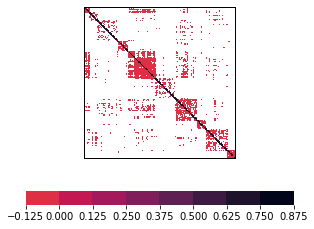

In [84]:
mmdutils.plot_corr(prec)

In [74]:
np.linalg.inv(prec)

array([[1.5       , 0.02997485, 0.00416839, ..., 0.01640713, 0.04359474,
        0.16114251],
       [0.02997485, 1.5       , 0.00475101, ..., 0.02956062, 0.05146142,
        0.07588558],
       [0.00416839, 0.00475101, 1.5       , ..., 0.00278778, 0.00610114,
        0.02195069],
       ...,
       [0.01640713, 0.02956062, 0.00278778, ..., 1.5       , 0.03884707,
        0.04808067],
       [0.04359474, 0.05146142, 0.00610114, ..., 0.03884707, 1.5       ,
        0.1625845 ],
       [0.16114251, 0.07588558, 0.02195069, ..., 0.04808067, 0.1625845 ,
        1.5       ]])

# Graphical Lasso

<AxesSubplot:>

<Figure size 1080x1080 with 0 Axes>

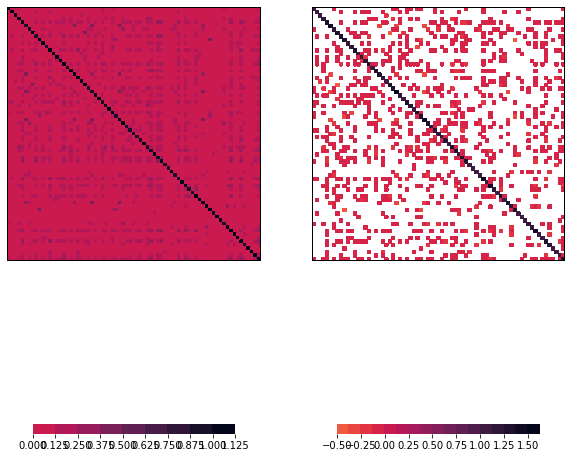

In [56]:
from sklearn.covariance import GraphicalLasso
#glasso =  graphical_lasso.graphical_lasso_wrapper(emp_cov=corr_x, alpha=0.5, N = x.shape[0], beta = 0.01)
# best_prec, prec_list, cov_list, ebic_vals, best_alpha, alpha_list = glasso.fit_CV()
# best_prec = glasso.fit_mm(reltol=1e-5, max_itr=100)
#best_cov, best_prec = glasso.fit_sklearn()
cov = GraphicalLasso(alpha=0.5, mode = 'LARS').fit(x_scaled)
best_cov = cov.covariance_.copy()
best_prec = cov.precision_.copy()
plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(1,2, figsize = (10, 20))
mmdutils.plot_corr(best_cov, ax = ax[0])
mmdutils.plot_corr(best_prec, ax = ax[1])

In [58]:
best_prec

array([[ 1.06922398, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.09203454],
       [-0.        ,  1.07390242, -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  1.04634004, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ...,  1.10893584,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
         1.12256661, -0.04260937],
       [-0.09203454, -0.        , -0.        , ..., -0.        ,
        -0.04260937,  1.35495078]])

In [57]:
np.linalg.inv(best_prec)

array([[1.00000756, 0.03928452, 0.00836563, ..., 0.02427613, 0.05395935,
        0.16113355],
       [0.03928452, 0.99999835, 0.00905617, ..., 0.03793295, 0.06485493,
        0.09009348],
       [0.00836563, 0.00905617, 0.99999993, ..., 0.00590515, 0.01156252,
        0.03292495],
       ...,
       [0.02427613, 0.03793295, 0.00590515, ..., 0.99999938, 0.04989904,
        0.06220321],
       [0.05395935, 0.06485493, 0.01156252, ..., 0.04989904, 0.99999705,
        0.16257803],
       [0.16113355, 0.09009348, 0.03292495, ..., 0.06220321, 0.16257803,
        0.99998747]])

# Graphical Lasso ledoitWolf

<AxesSubplot:>

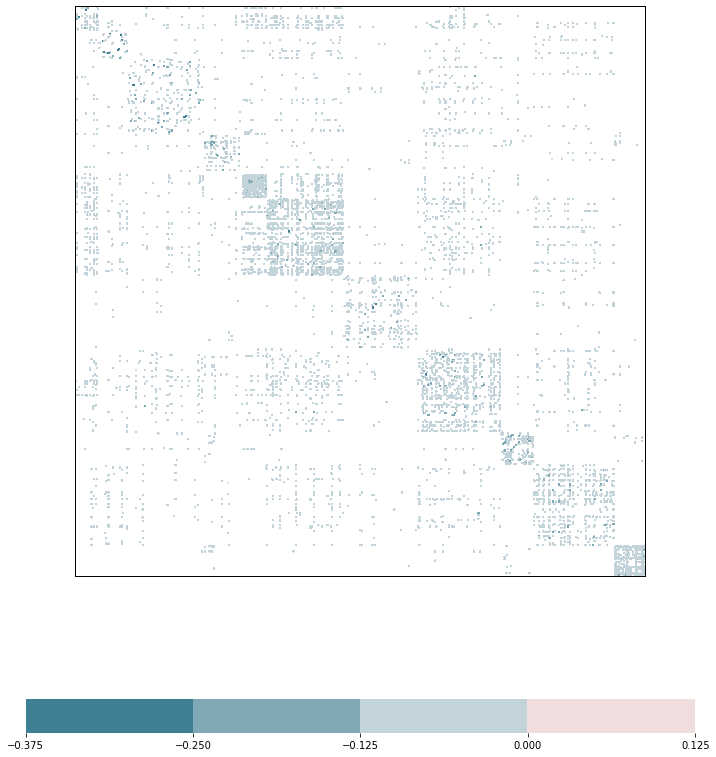

In [278]:
importlib.reload(sys.modules['gradient_descent'])
importlib.reload(sys.modules['graphical_lasso'])
glasso_lwolf =  graphical_lasso.graphical_lasso_wrapper(emp_cov=lwolf_corr_x, alpha=0.5, N = x.shape[0], beta = 0.01)
best_cov_lwolf, best_prec_lwolf = glasso_lwolf.fit_sklearn()
plt.figure(figsize=(15, 15))
np.fill_diagonal(best_prec_lwolf, 0)
mmdutils.plot_corr(best_prec_lwolf)

# Graphical Lasso rocke

In [12]:
RobStatTM = importr('RobStatTM')

In [52]:
importlib.reload(sys.modules['covariance'])
_, rocke_corr, _  = covariance.S_estimation_cov(np.array(x_scaled), initial='K', maxsteps=5, propmin=0.1, qs=2, maxit=200, tol=1e-4, corr=False)
rocke_corr = covariance.corrMat(rocke_corr)


<AxesSubplot:>

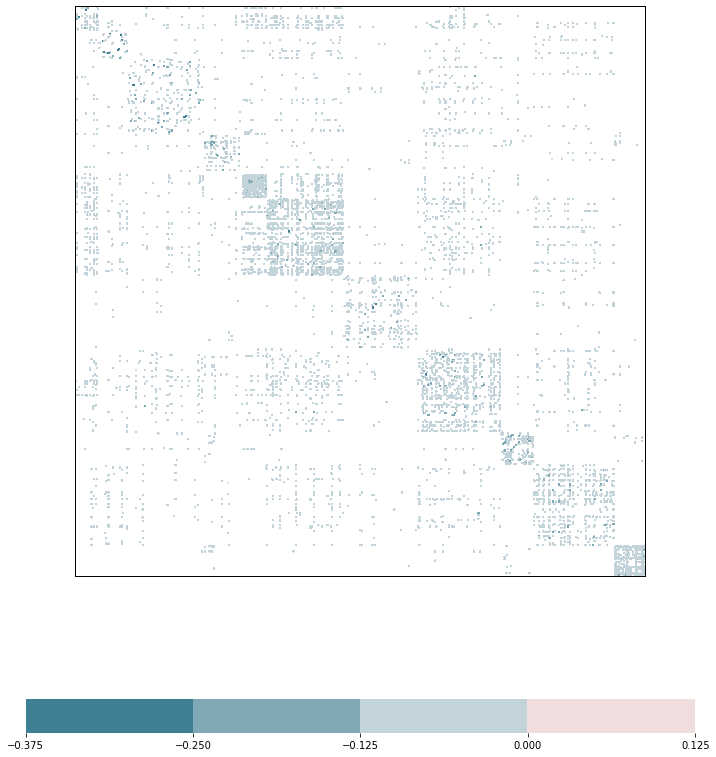

In [53]:
glasso_rocke =  graphical_lasso.graphical_lasso_wrapper(emp_cov=lwolf_corr_x, alpha=0.5, N = x.shape[0], beta = 0.01)
best_cov_rocke, best_prec_rocke = glasso_rocke.fit_sklearn()
plt.figure(figsize=(15, 15))
np.fill_diagonal(best_prec_rocke, 0)
mmdutils.plot_corr(best_prec_rocke)

# Graphical lasso Market removed

<AxesSubplot:>

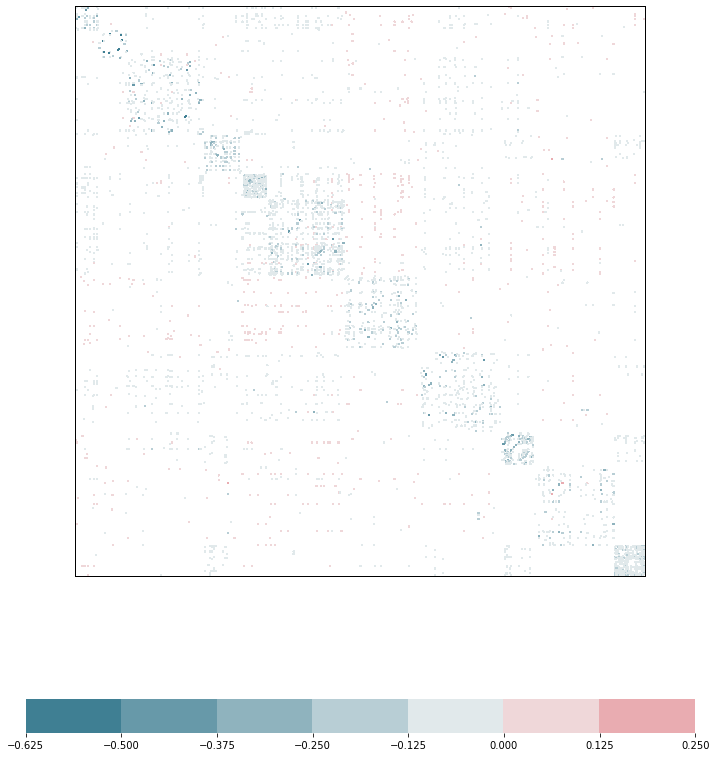

In [38]:
glasso_no_market =  graphical_lasso.graphical_lasso_wrapper(emp_cov=np.corrcoef(np.array(x_no_market).T), alpha=0.5, N = x.shape[0], beta = 0.01)
# best_prec, prec_list, cov_list, ebic_vals, best_alpha, alpha_list = glasso.fit_CV()
# best_prec = glasso.fit_mm(reltol=1e-5, max_itr=100)
best_cov_no_market, best_prec_no_market = glasso_no_market.fit_sklearn()
plt.figure(figsize=(15, 15))
np.fill_diagonal(best_prec_no_market, 0)
mmdutils.plot_corr(best_prec_no_market)

# Graphical lasso Market removed Ledoit Wolf

<AxesSubplot:>

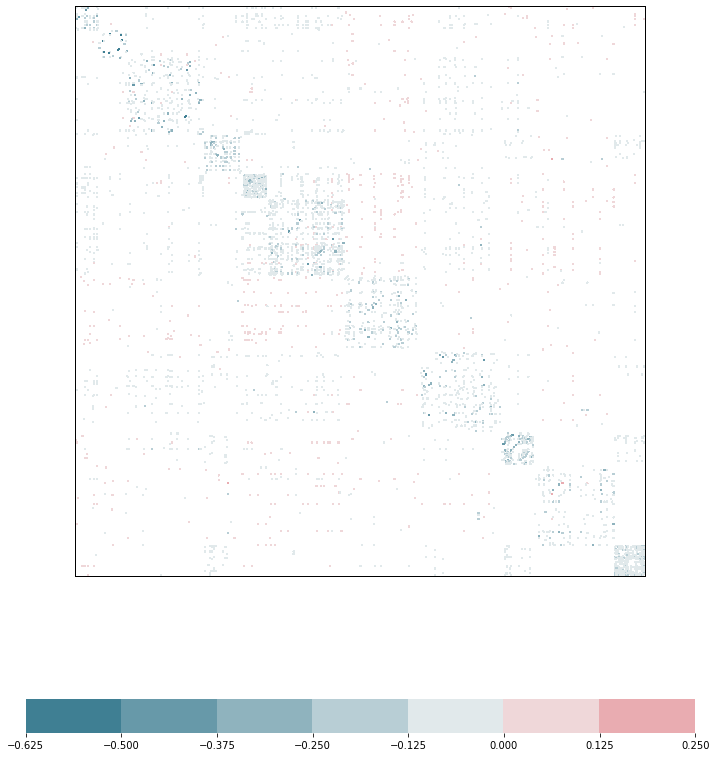

In [42]:

lwolf = LedoitWolf().fit(x_no_market_scaled)
lwolf_corr_x_no_market = covariance.corrMat(lwolf.covariance_)

glasso_no_market_lwolf =  graphical_lasso.graphical_lasso_wrapper(emp_cov=lwolf_corr_x_no_market, alpha=0.5, N = x.shape[0], beta = 0.01)
# best_prec, prec_list, cov_list, ebic_vals, best_alpha, alpha_list = glasso.fit_CV()
# best_prec = glasso.fit_mm(reltol=1e-5, max_itr=100)
best_cov_no_market_lwolf, best_prec_no_market_lwolf = glasso_no_market.fit_sklearn()
plt.figure(figsize=(15, 15))
np.fill_diagonal(best_prec_no_market_lwolf, 0)
mmdutils.plot_corr(best_prec_no_market_lwolf)


# Graphical Lsso rocke market removed

<AxesSubplot:>

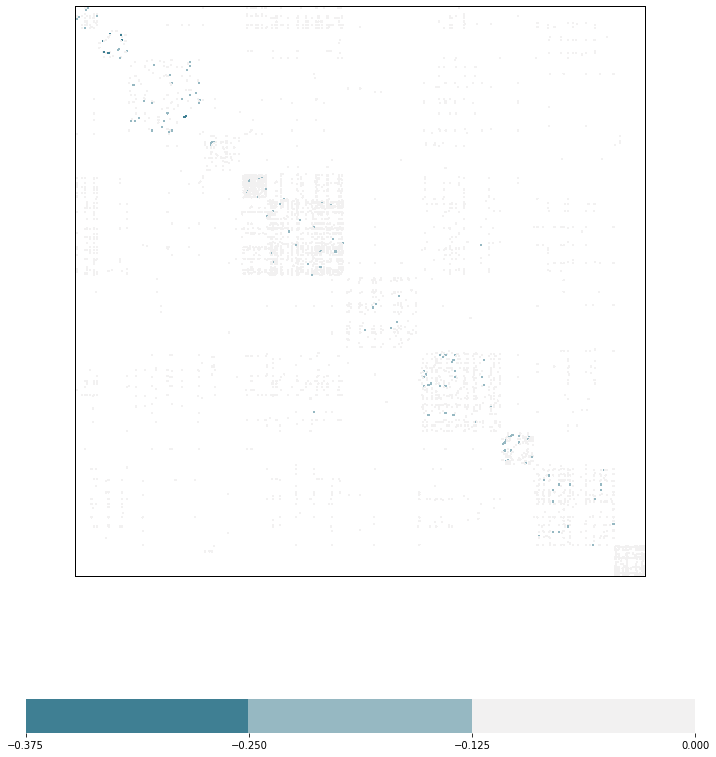

In [49]:
 importlib.reload(sys.modules['covariance'])
_, rocke_corr_no_market, _  = covariance.S_estimation_cov(np.array(x_no_market_scaled), initial='K', maxsteps=5, propmin=0.1, qs=2, maxit=200, tol=1e-4, corr=False)
rocke_corr_no_market = covariance.corrMat(rocke_corr_no_market)

glasso_rocke_no_market =  graphical_lasso.graphical_lasso_wrapper(emp_cov=rocke_corr_no_market, alpha=0.5, N = x.shape[0], beta = 0.01)
best_cov_rocke_no_market, best_prec_rocke_no_market = glasso_rocke.fit_sklearn()
plt.figure(figsize=(15, 15))
np.fill_diagonal(best_prec_rocke_no_market, 0)
mmdutils.plot_corr(best_prec_rocke_no_market)

## Graphical TLasso

In [273]:
import  graphical_lasso 
importlib.reload(sys.modules['graphical_lasso'])

tlasso =  graphical_lasso.tlasso(x = x_no_market_scaled, emp_cov = x_no_market_corr, alpha = 0.5, nu = 5, mu_init = np.zeros(x.shape[1]), Theta_init = np.identity(x.shape[1]), mu_zero = True)
prec_tlasso = lasso.fit(reltol= 5e-5)

0 / 1000, inf
 0 / 1000


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\sklearn\covariance\_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3158092725170718, tolerance: 0.18525413557865458
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\sklearn\covariance\_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5940957722943949, tolerance: 0.18525413557865456
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\sklearn\covariance\_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9237408237252112, tolerance: 0.18525413557865383
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\U

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [63]:
prec_tlasso

array([[ 1.83151182e-02, -0.00000000e+00,  0.00000000e+00, ...,
        -1.59609558e-03, -3.71262806e-04,  0.00000000e+00],
       [-0.00000000e+00,  2.07005459e-02, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -1.86754177e-06],
       [ 0.00000000e+00, -0.00000000e+00,  1.31046536e-02, ...,
         0.00000000e+00,  2.97880952e-03,  0.00000000e+00],
       ...,
       [-1.59609558e-03, -0.00000000e+00,  0.00000000e+00, ...,
         1.09252324e-02,  9.35062506e-04, -0.00000000e+00],
       [-3.71262806e-04, -0.00000000e+00,  2.97880952e-03, ...,
         9.35062506e-04,  1.27993981e-02, -0.00000000e+00],
       [ 0.00000000e+00, -1.86754177e-06,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  1.17651800e-02]])

In [213]:
mmdutils.plot_corr(prec_tlasso)

ValueError: There are 819 color bins including extensions, but ncolors = 256; ncolors must equal or exceed the number of bins

# Algorithms for Learning Graphs in Financial Markets

Load R scripts into the ro global environment. These

In [50]:
rpy2.robjects.numpy2ri.activate()
ro.r('''source('../fingraph/connected_graph_admm.R')''')
learn_connected_graph = ro.globalenv['learn_connected_graph']
learn_heavy_connected_graph = ro.globalenv['learn_regular_heavytail_graph']
learn_heavy_k_component_graph = ro.globalenv['learn_kcomp_heavytail_graph']

In [51]:
out_connected_normal = learn_connected_graph(corr_x, verbose = True)
out_connected_normal[4]
# n = 199, p = 502 -> 14m 4.6s
# n = 30, p = 502 -> 8m 13.7s

1


In [63]:
out_connected_normal_rocke = learn_connected_graph(rocke_corr, verbose = True)
out_connected_normal_rocke[4]
# n = 199, p = 502 -> 14m 4.6s
# n = 30, p = 502 -> 8m 13.7s

1


In [100]:
out_connected_heavy = learn_heavy_connected_graph(x_scaled, heavy_type = 'student', nu = 5, verbose = True)
out_connected_heavy[4]
# n = 30, p = 502 -> 14m 16.8s

0


In [8]:
out_k_comp_heavy = learn_heavy_k_component_graph(x_scaled, heavy_type = 'student', nu = 5, k = 11, verbose = True)
out_k_comp_heavy[4]

[1] "verbose"
[1] "1 / 10000"
[1] "2 / 10000"
[1] "3 / 10000"
[1] "4 / 10000"
[1] "5 / 10000"
[1] "6 / 10000"
[1] "7 / 10000"
[1] "8 / 10000"
[1] "9 / 10000"
[1] "10 / 10000"
[1] "11 / 10000"
[1] "12 / 10000"
[1] "13 / 10000"
[1] "14 / 10000"
[1] "15 / 10000"
[1] "16 / 10000"
[1] "17 / 10000"
[1] "18 / 10000"
[1] "19 / 10000"
[1] "20 / 10000"
[1] "21 / 10000"
[1] "22 / 10000"
[1] "23 / 10000"
[1] "24 / 10000"
[1] "25 / 10000"
[1] "26 / 10000"
[1] "27 / 10000"
[1] "28 / 10000"
[1] "29 / 10000"
[1] "30 / 10000"
[1] "31 / 10000"
[1] "32 / 10000"
[1] "33 / 10000"
[1] "34 / 10000"
[1] "35 / 10000"
[1] "36 / 10000"
[1] "37 / 10000"
[1] "38 / 10000"
[1] "39 / 10000"
[1] "40 / 10000"
[1] "41 / 10000"
[1] "42 / 10000"
[1] "43 / 10000"
[1] "44 / 10000"
[1] "45 / 10000"
[1] "46 / 10000"
[1] "47 / 10000"
[1] "48 / 10000"
[1] "49 / 10000"
[1] "50 / 10000"
[1] "51 / 10000"
[1] "52 / 10000"
[1] "53 / 10000"
[1] "54 / 10000"
[1] "55 / 10000"
[1] "56 / 10000"
[1] "57 / 10000"
[1] "58 / 10000"
[1] "59 /

0


Save the data so we do not have to re-run.

In [34]:
# with open('../data/SingleGraphTest/normal.pkl', 'wb') as f:
#         pickle.dump(out_connected_normal, f)

with open('../data/SingleGraphTest/heavy.pkl', 'wb') as f:
        pickle.dump(out_connected_heavy, f)

# with open('../data/SingleGraphTest/k_heavy.pkl', 'wb') as f:
#         pickle.dump(out_k_comp_heavy, f)

In [64]:
L_normal = out_connected_normal[0]
# L_heavy = out_connected_heavy[0]
#L_k_heavy = out_k_comp_heavy[0]

A_normal = out_connected_normal[1]
A_normal_rocke = out_connected_normal_rocke[1]
# A_heavy = out_connected_heavy[1]
#A_k_heavy = out_k_comp_heavy[1]

In [22]:
def LtoA(L):
    """
    Return adjacency matrix from graph Laplacian
    """

    return np.diag(np.diag(L)) - L

Fit a graphical Lasso.

Text(0.5, 1.0, 'Spectral laplacian')

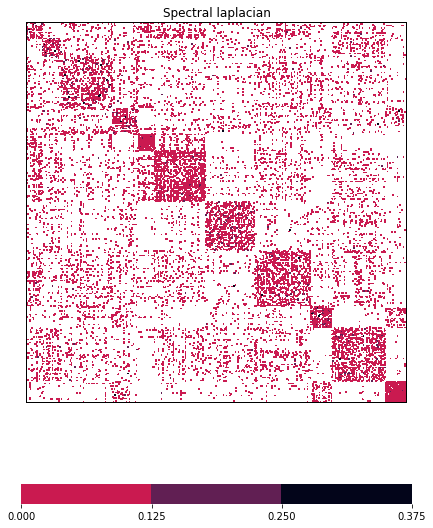

In [78]:
#fig, ax = plt.subplots(1,3, figsize = (20, 10))
fig, ax = plt.subplots(1,1, figsize = (20, 10))

mmdutils.plot_corr(A_normal_rocke, ax = ax, cbar_length= 0.35)
ax.set_title('Spectral laplacian')

# mmdutils.plot_corr(A_heavy, ax = ax[1])
# ax[1].set_title('Heavy Connected Graph')

#mmdutils.plot_corr(A_k_heavy, ax = ax[2])
#ax[2].set_title('Heavy k-component Graph')

In [59]:
index = np.array(range(x.shape[1]))
i_sector = index[x.columns.isin(sector_classification['Industrials'])]
C_samp_sector = C_samp[np.ix_(i_sector, i_sector)]
C_null_sector = C_null[np.ix_(i_sector, i_sector)]
x_sector = np.array(x)[:,i_sector]
print(x_sector.shape)
C_samp_sector.shape

(110, 73)


(73, 73)

In [42]:
importlib.reload(sys.modules['mmdutils'])
importlib.reload(sys.modules['my_scola'])
tt = my_scola.Scola()
for l in np.linspace(0, 1,100):
    W = tt.detect(C_samp_sector, C_null_sector, l)
    print(f'{l} {mmdutils._comp_EBIC(W, C_samp_sector, C_null_sector, x.shape[0], 0.5, 0, "cov")} {mmdutils._comp_loglikelihood(W,C_samp_sector, C_null_sector, "cov")}')

0.0 47659.917611311685 -57.98363812424216
0.010101010101010102 19617.14468754198 -63.57196093796436
0.020202020202020204 21585.31886089365 -84.77331648666336
0.030303030303030304 21058.427079749094 -91.31311333926628
0.04040404040404041 24165.46253708046 -105.4360017816816
0.05050505050505051 21508.2732209037 -95.35007841354604
0.06060606060606061 17247.716248656292 -77.01020029977381
0.07070707070707072 16855.21633023497 -75.28647975807729
0.08080808080808081 16775.259079807103 -75.1645176970068
0.09090909090909091 15570.873115245888 -69.87114602965704
0.10101010101010102 16673.915264089886 -74.76423398578349
0.11111111111111112 15881.090804528414 -71.64344641498005
0.12121212121212122 16066.159184176306 -72.66577631221713
0.13131313131313133 16357.601491905612 -73.74903408829418
0.14141414141414144 18554.93065849954 -83.91800392619507
0.15151515151515152 16843.121557178023 -76.19742346222495
0.16161616161616163 15750.095587695276 -71.34986359410418
0.17171717171717174 16418.209250359

In [ ]:
 W = tt.detect(C_samp_sector, C_null_sector, 0.28)
 mmdutils.plot_corr(W)
 np.sum(W, axis = 1)

In [83]:
importlib.reload(sys.modules['mmdutils'])
importlib.reload(sys.modules['my_scola'])
importlib.reload(sys.modules['gradient_descent'])
tt = my_scola.Scola(likelihood='mvt')
for l in np.linspace(0, 1,100):
    W = tt.detect(C_samp_sector, C_null_sector, l, x = np.array(x_sector))
    print(f'{l} {mmdutils._comp_EBIC(W, C_samp_sector, C_null_sector, x.shape[0], 0.5, 0, "cov")} {mmdutils._comp_loglikelihood(W,C_samp_sector, C_null_sector, "cov")}')

0
0
0
0


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\my_scola.py:61: RuntimeWarning: invalid value encountered in log
  


0
0
0
0
0
0
0
0
0.0 41684.95139533405 -30.82470077888923
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.010101010101010102 17394.97991584699 -45.56274242344312
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.020202020202020204 14756.061004162251 -46.42646573325339
0
0


KeyboardInterrupt: 

0
0
0
0
0
0
0
0

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\my_scola.py:61: RuntimeWarning: invalid value encountered in log
  l = L * np.log(gamma((nu + p)/2.0)) - L * np.log(gamma(nu / 2.0)) - L * (p/2.0) * np.log(nu) - L * (p/2.0) * np.log(p) - L * 0.5 * np.sum(np.log(w)) + L * np.log(nu) - ((nu + p) / 2.0) * np.sum(np.log(nu + nu * d))



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<AxesSubplot:>

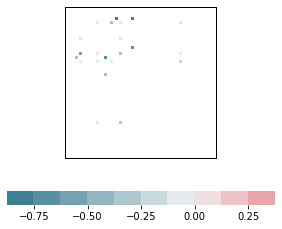

In [84]:
 importlib.reload(sys.modules['my_scola'])
 W = tt.detect(C_samp_sector, C_null_sector, 0.08, x = np.array(x_sector))
 mmdutils.plot_corr(W)
 #np.sum(W, axis = 1)

# DCC-GARCH

In [6]:
importlib.reload(sys.modules['mgarch'])
vol = mgarch.mgarch()
vol.fit(np.array(x))

starting garch
0 / 10
garch finished, onto DCC


{'mu': matrix([[ 0.00315307,  0.00248246, -0.00122304,  0.00074525, -0.00054224,
           0.00137466,  0.00128191,  0.00150859,  0.00029409,  0.0011868 ]]),
 'alpha': 0.0005067962768033355,
 'beta': 0.795576494392114}

# ASDF